<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/MultipleChoice_Task_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MultipleChoice Task with Transfer Learning**

## Introduction

In this example, we will demonstrate how to perform the **MultipleChoice** task by
finetuning pre-trained DebertaV3 model. In this task, several candidate answers are
provided along with a context and the model is trained to select the correct answer
unlike question answering. We will use SWAG dataset to demonstrate this example.

In [1]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.8/584.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.1/999.1 kB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.1 which is incompatible.


In [2]:
import keras
import keras_nlp
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

####**Dataset**

In this example we'll use SWAG dataset for multiplechoice task.

In [3]:
!wget "https://github.com/rowanz/swagaf/archive/refs/heads/master.zip" -O swag.zip
!unzip -q swag.zip

--2023-12-16 15:59:15--  https://github.com/rowanz/swagaf/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/rowanz/swagaf/zip/refs/heads/master [following]
--2023-12-16 15:59:15--  https://codeload.github.com/rowanz/swagaf/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘swag.zip’

swag.zip                [      <=>           ]  19.94M  5.69MB/s    in 3.5s    

2023-12-16 15:59:19 (5.69 MB/s) - ‘swag.zip’ saved [20905751]



In [4]:
!ls swagaf-master/data

README.md  test.csv  train.csv	train_full.csv	val.csv  val_full.csv


In [5]:
class CFG:
    preset = "deberta_v3_extra_small_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length
    seed = 42  # Random seed
    epochs = 5  # Training epochs
    batch_size = 8  # Batch size
    augment = True  # Augmentation (Shuffle Options)

In [6]:
tf.random.set_seed(CFG.seed)

## Meta Data
* **train.csv** - will be used for training.
* `sent1` and `sent2`: these fields show how a sentence starts, and if you put the two
together, you get the `startphrase` field.
* `ending_<i>`: suggests a possible ending for how a sentence can end, but only one of
them is correct.
    * `label`: identifies the correct sentence ending.

* **val.csv** - similar to `train.csv` but will be used for validation.

In [7]:
train_df = pd.read_csv("/content/swagaf-master/data/train.csv", index_col = 0)
train_df = train_df.sample(frac = 0.02)
print("train data length is ::", len(train_df))


val_df = pd.read_csv("/content/swagaf-master/data/val.csv", index_col = 0)
val_df = val_df.sample(frac = 0.02)
print("validation data length is :: ", len(val_df))

train data length is :: 1471
validation data length is ::  400


In [8]:
train_df.head(1)

,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label
13159,lsmdc3083_TITANIC2-39387,4058,She pulls him through the sitting room toward ...,She pulls him through the sitting room toward ...,Someone,gold,enters her own room.,steps into the suite.,walks out of the room and walks out of the shop.,enters and sits on his bed.,1


In [9]:
train_df.label.value_counts()

2    408
3    360
0    352
1    351
Name: label, dtype: int64

## Contextualize Options

Our approach entails furnishing the model with question and answer pairs, as opposed to
employing a single question for all five options. In practice, this signifies that for
the five options, we will supply the model with the same set of five questions combined
with each respective answer choice (e.g., `(Q + A)`, `(Q + B)`, and so on). This analogy
draws parallels to the practice of revisiting a question multiple times during an exam to
promote a deeper understanding of the problem at hand.

> Notably, in the context of SWAG dataset, question is the start of a sentence and
options are possible ending of that sentence.

In [10]:
# Define a function to create options based on the prompt and choices
def make_options(row):
    row["options"] = [
        f"{row.startphrase}\n{row.ending0}",  # Option 0
        f"{row.startphrase}\n{row.ending1}",  # Option 1
        f"{row.startphrase}\n{row.ending2}",  # Option 2
        f"{row.startphrase}\n{row.ending3}",
    ]  # Option 3
    return row

In [11]:
train_df = train_df.apply(make_options, axis = 1)
valid_df = val_df.apply(make_options, axis = 1)

In [12]:
train_df.options.values[0]

['She pulls him through the sitting room toward a door. Someone\nenters her own room.',
 'She pulls him through the sitting room toward a door. Someone\nsteps into the suite.',
 'She pulls him through the sitting room toward a door. Someone\nwalks out of the room and walks out of the shop.',
 'She pulls him through the sitting room toward a door. Someone\nenters and sits on his bed.']

## Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a
dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process
starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling
due to its high dimensionality. By converting text into a compact set of tokens, such as
transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`,
we simplify the data. Many models rely on special tokens and additional tensors to
understand input. These tokens help divide input and identify padding, among other tasks.
Making all sequences the same length through padding boosts computational efficiency,
making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in
**KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [13]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
              preset = CFG.preset,
              sequence_length = CFG.sequence_length)

2464616/2464616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Now, let's examine what the output shape of the preprocessing layer looks like. The
output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [14]:
outs = preprocessor(train_df.options.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

token_ids : (4, 200)
padding_mask : (4, 200)


In [15]:
def preprocess_fn(text, label = None):
    text = preprocessor(text)
    return ((text, label) if label is not None else text)

## Augmentation

In this notebook, we'll experiment with an interesting augmentation technique,
`option_shuffle`. Since we're providing the model with one option at a time, we can
introduce a shuffle to the order of options. For instance, options `[A, C, E, D, B]`
would be rearranged as `[D, B, A, E, C]`. This practice will help the model focus on the
content of the options themselves, rather than being influenced by their positions.

**Note:** Even though `option_shuffle` function is written in pure
tensorflow, it can be used with any backend (e.g. JAX, PyTorch) as it is only used
in `tf.data.Dataset` pipeline which is compatible with Keras 3 routines.

In [16]:
def option_shuffle(options, labels, prob=0.50, seed=None):
    if tf.random.uniform([]) > prob:  # Shuffle probability check
        return options, labels
    # Shuffle indices of options and labels in the same order
    indices = tf.random.shuffle(tf.range(tf.shape(options)[0]), seed=seed)
    # Shuffle options and labels
    options = tf.gather(options, indices)
    labels = tf.gather(labels, indices)
    return options, labels

In the following function, we'll merge all augmentation functions to apply to the text.
These augmentations will be applied to the data using the `dataset.map(augment_fn)`
approach.

In [17]:
def augment_fn(text, label = None):
    text, label = option_shuffle(text, label, prob = 0.5)
    return (text, label) if label is not None else text

## DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data
processing. Notable aspects of `tf.data` include its ability to simplify pipeline
construction and represent components in sequences.

To learn more about `tf.data`, refer to this
[documentation](https://www.tensorflow.org/guide/data).

In [18]:
def build_dataset(texts, labels=None, batch_size=32, cache=False, augment=False, repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (
        (texts,)
        if labels is None
        else (texts, keras.utils.to_categorical(labels, num_classes=4)))  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    if augment:  # Apply augmentation if enabled
        ds = ds.map(augment_fn, num_parallel_calls=AUTO)
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=True)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

In [19]:
# Build train dataloader
train_texts = train_df.options.tolist()  # Extract training texts
train_labels = train_df.label.tolist()  # Extract training labels
train_ds = build_dataset(
    train_texts,
    train_labels,
    batch_size=CFG.batch_size,
    cache=True,
    shuffle=True,
    repeat=True,
    augment=CFG.augment,
)

# Build valid dataloader
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_labels = valid_df.label.tolist()  # Extract validation labels
valid_ds = build_dataset(
    valid_texts,
    valid_labels,
    batch_size=CFG.batch_size,
    cache=True,
    shuffle=False,
    repeat=False,
    augment=False,
)

## LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning
rate initiates at `lr_start` and gradually tapers down to `lr_min` using **cosine**
curve.

**Importance:** A well-structured learning rate schedule is essential for efficient model
training, ensuring optimal convergence and avoiding issues such as overshooting or
stagnation.

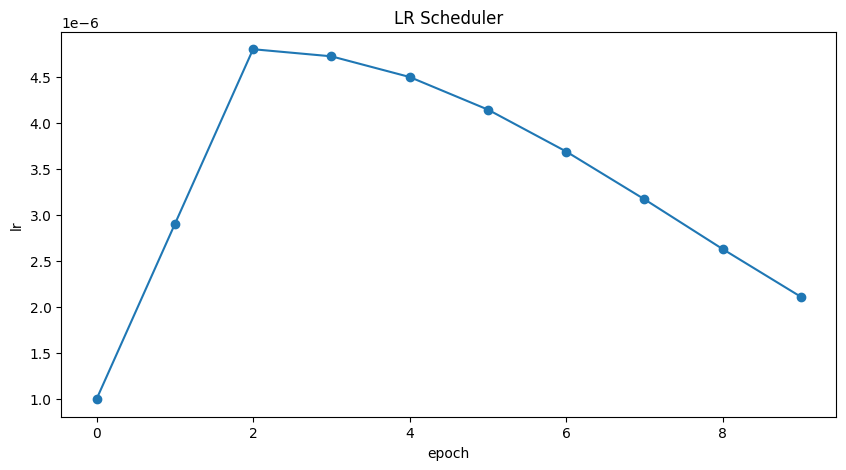

In [20]:
import math


def get_lr_callback(batch_size=8, mode="cos", epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep = 2, 0

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            decay_total_epochs, decay_epoch_index = (
                epochs - lr_ramp_ep - lr_sus_ep + 3,
                epoch - lr_ramp_ep - lr_sus_ep,
            )
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(
            np.arange(epochs),
            [lrfn(epoch) for epoch in np.arange(epochs)],
            marker="o",
        )
        plt.xlabel("epoch")
        plt.ylabel("lr")
        plt.title("LR Scheduler")
        plt.show()

    return keras.callbacks.LearningRateScheduler(
        lrfn, verbose=False
    )  # Create lr callback


_ = get_lr_callback(CFG.batch_size, plot=True)

## Callbacks

The function below will gather all the training callbacks, such as `lr_scheduler`,
`model_checkpoint`.

In [21]:
def get_callbacks():
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size)  # Get lr callback
    ckpt_cb = keras.callbacks.ModelCheckpoint(
        f"best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
    )  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks
    return callbacks  # Return the list of callbacks


callbacks = get_callbacks()

## MultipleChoice Model









### Pre-trained Models

The `KerasNLP` library provides comprehensive, ready-to-use implementations of popular
NLP model architectures. It features a variety of pre-trained models including `Bert`,
`Roberta`, `DebertaV3`, and more. In this notebook, we'll showcase the usage of
`DistillBert`. However, feel free to explore all available models in the [KerasNLP
documentation](https://keras.io/api/keras_nlp/models/). Also for a deeper understanding
of `KerasNLP`, refer to the informative [getting started
guide](https://keras.io/guides/keras_nlp/getting_started/).

Our approach involves using `keras_nlp.models.XXClassifier` to process each question and
option pari (e.g. (Q+A), (Q+B), etc.), generating logits. These logits are then combined
and passed through a softmax function to produce the final output.




### Classifier for Multiple-Choice Tasks

When dealing with multiple-choice questions, instead of giving the model the question and
all options together `(Q + A + B + C ...)`, we provide the model with one option at a
time along with the question. For instance, `(Q + A)`, `(Q + B)`, and so on. Once we have
the prediction scores (logits) for all options, we combine them using the `Softmax`
function to get the ultimate result. If we had given all options at once to the model,
the text's length would increase, making it harder for the model to handle. The picture
below illustrates this idea:

![Model Diagram](https://pbs.twimg.com/media/F3NUju_a8AAS8Fq?format=png&name=large)

<div align="center"><b> Picture Credict: </b> <a
href="https://twitter.com/johnowhitaker"> @johnowhitaker </a> </div></div><br>

From a coding perspective, remember that we use the same model for all five options, with
shared weights. Despite the figure suggesting five separate models, they are, in fact,
one model with shared weights. Another point to consider is the the input shapes of
Classifier and MultipleChoice.

* Input shape for **Multiple Choice**: $(batch\_size, num\_choices, seq\_length)$
* Input shape for **Classifier**: $(batch\_size, seq\_length)$

Certainly, it's clear that we can't directly give the data for the multiple-choice task
to the model because the input shapes don't match. To handle this, we'll use **slicing**.
This means we'll separate the features of each option, like $feature_{(Q + A)}$ and
$feature_{(Q + B)}$, and give them one by one to the NLP classifier. After we get the
prediction scores $logits_{(Q + A)}$ and $logits_{(Q + B)}$ for all the options, we'll
use the Softmax function, like $\operatorname{Softmax}([logits_{(Q + A)}, logits_{(Q +
B)}])$, to combine them. This final step helps us make the ultimate decision or choice.

> Note that in the classifier, we set `num_classes=1` instead of `5`. This is because the
classifier produces a single output for each option. When dealing with five options,
these individual outputs are joined together and then processed through a softmax
function to generate the final result, which has a dimension of `5`.

In [22]:
# Selects one option from five
class SelectOption(keras.layers.Layer):
    def __init__(self, index, **kwargs):
        super().__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        # Selects a specific slice from the inputs tensor
        return inputs[:, self.index, :]

    def get_config(self):
        # For serialize the model
        base_config = super().get_config()
        config = {
            "index": self.index,
        }
        return {**base_config, **config}


def build_model():
    # Define input layers
    inputs = {
        "token_ids": keras.Input(shape=(4, None), dtype="int32", name="token_ids"),
        "padding_mask": keras.Input(
            shape=(4, None), dtype="int32", name="padding_mask"
        ),
    }
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1,  # one output per one option, for five options total 5 outputs
    )
    logits = []
    # Loop through each option (Q+A), (Q+B) etc and compute associted logits
    for option_idx in range(4):
        option = {
            k: SelectOption(option_idx, name=f"{k}_{option_idx}")(v)
            for k, v in inputs.items()
        }
        logit = classifier(option)
        logits.append(logit)

    # Compute final output
    logits = keras.layers.Concatenate(axis=-1)(logits)
    outputs = keras.layers.Softmax(axis=-1)(logits)
    model = keras.Model(inputs, outputs)

    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=keras.optimizers.AdamW(5e-6),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
        jit_compile=True,
    )
    return model


# Build the Build
model = build_model()

282979000/282979000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, 4, None)        │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ token_ids (InputLayer)    │ (None, 4, None)        │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ padding_mask_0            │ (None, None)           │          0 │ padding_mask[0][0]         │
│ (SelectOption)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ token_ids_0               │ (None, None)           │          0 │ token_ids[0][0]            │
│ (SelectOption)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ padding_mask_1            │ (None, None)           │          0 │ padding_mask[0][0]         │
│ (SelectOption)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ token_ids_1               │ (None, None)           │          0 │ token_ids[0][0]            │
│ (SelectOption)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ padding_mask_2            │ (None, None)           │          0 │ padding_mask[0][0]         │
│ (SelectOption)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ token_ids_2               │ (None, None)           │          0 │ token_ids[0][0]            │
│ (SelectOption)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ padding_mask_3            │ (None, None)           │          0 │ padding_mask[0][0]         │
│ (SelectOption)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ token_ids_3               │ (None, None)           │          0 │ token_ids[0][0]            │
│ (SelectOption)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ deberta_v3_classifier     │ (None, 1)              │ 70,830,337 │ padding_mask_0[0][0],      │
│ (DebertaV3Classifier)     │                        │            │ token_ids_0[0][0],         │
│                           │                        │            │ padding_mask_1[0][0],      │
│                           │                        │            │ token_ids_1[0][0],         │
│                           │                        │            │ padding_mask_2[0][0],      │
│                           │                        │            │ token_ids_2[0][0],         │
│                           │                        │            │ padding_mask_3[0][0],      │
│                           │                        │            │ token_ids_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ concatenate (Concatenate) │ (None, 4)              │          0 │ deberta_v3_classifier[0][… │
│                      

 Total params: 70,830,337 (270.20 MB)

 Trainable params: 70,830,337 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

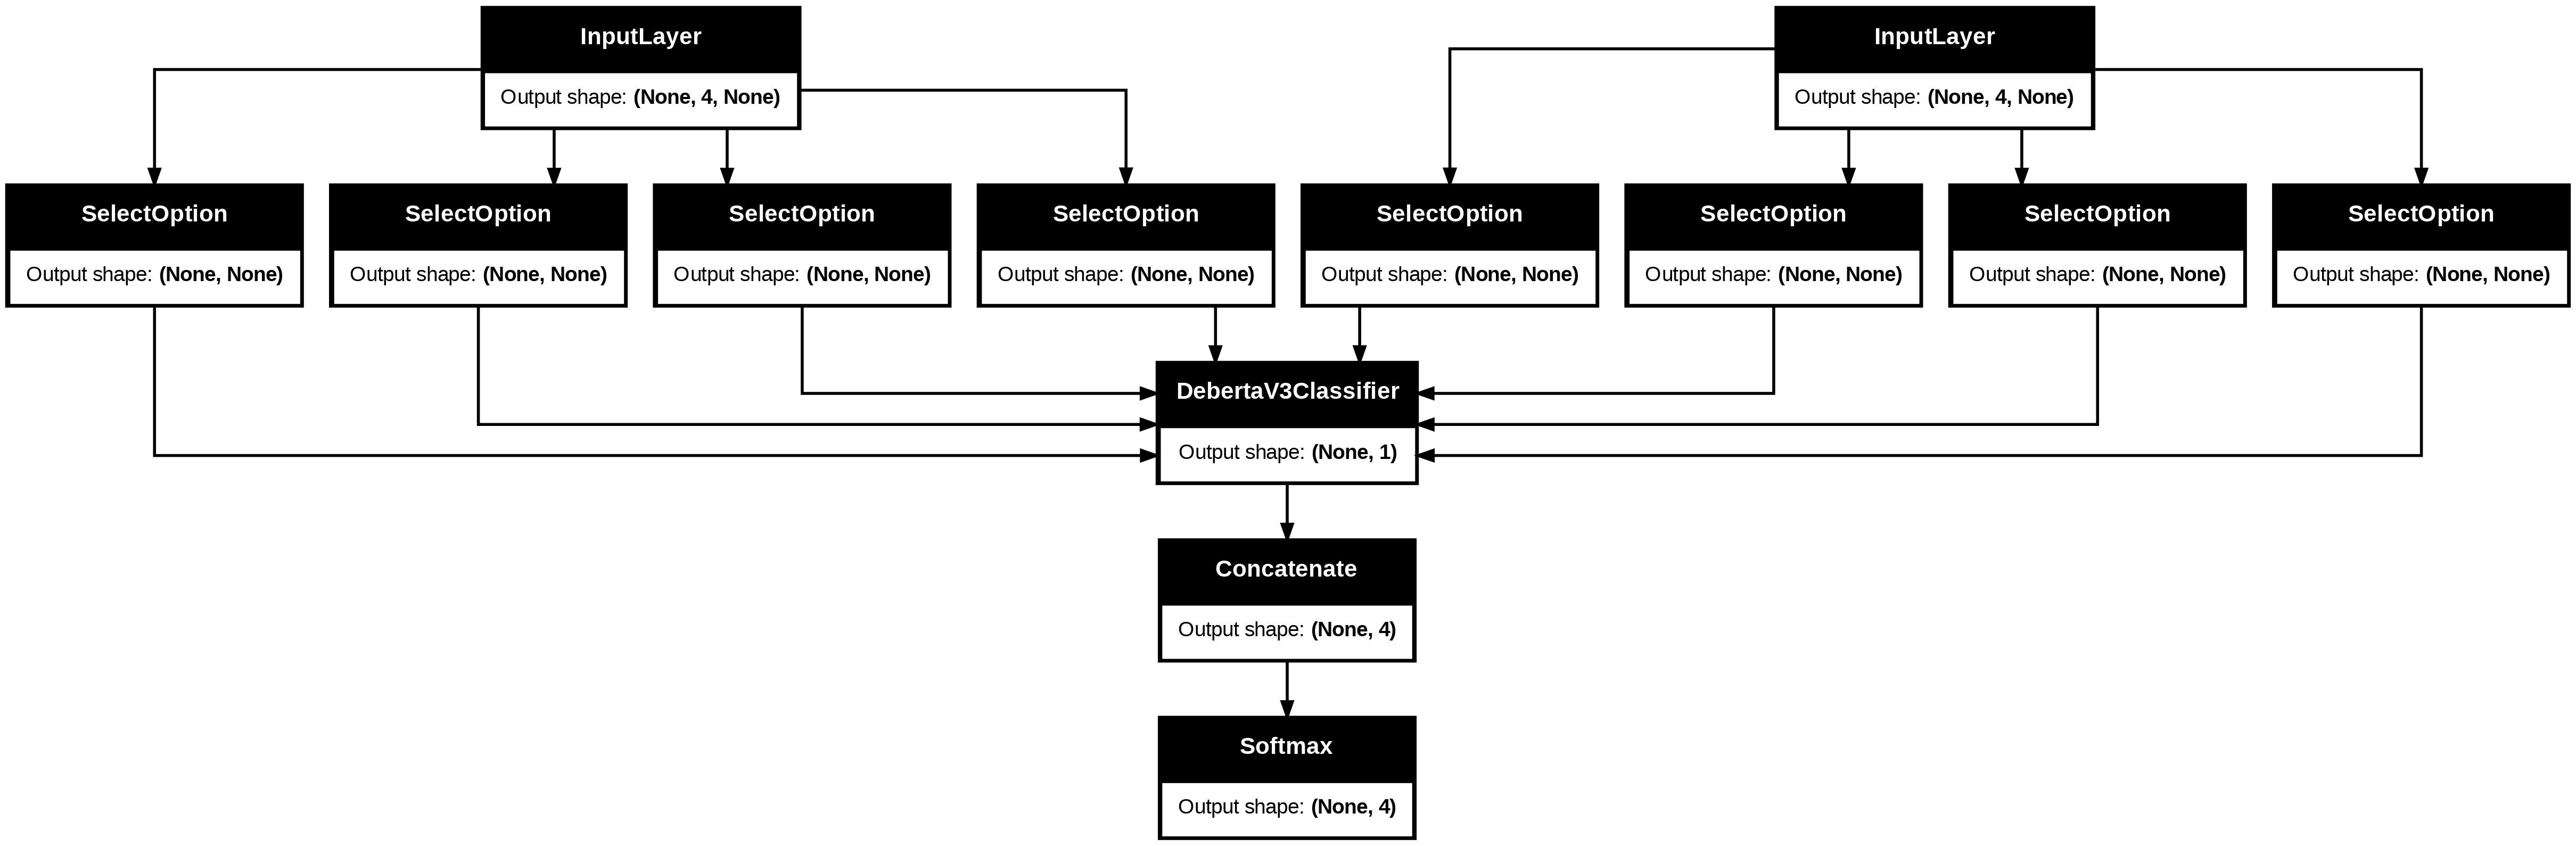

In [24]:
keras.utils.plot_model(model, show_shapes = True)

In [ ]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=callbacks,
    steps_per_epoch=int(len(train_df) / CFG.batch_size),
    verbose=1,
)

Epoch 1/5


## Inference

In [ ]:
# Make predictions using the trained model on last validation data
predictions = model.predict(
    valid_ds,
    batch_size=CFG.batch_size,  # max batch size = valid size
    verbose=1,
)

# Format predictions and true answers
pred_answers = np.arange(4)[np.argsort(-predictions)][:, 0]
true_answers = valid_df.label.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(0, 50, 10):
    row = valid_df.iloc[i]
    question = row.startphrase
    pred_answer = f"ending{pred_answers[i]}"
    true_answer = f"ending{true_answers[i]}"
    print(f"❓ Sentence {i+1}:\n{question}\n")
    print(f"✅ True Ending: {true_answer}\n   >> {row[true_answer]}\n")
    print(f"🤖 Predicted Ending: {pred_answer}\n   >> {row[pred_answer]}\n")
    print("-" * 90, "\n")


❓ Sentence 1:
The man shows the teens how to move the oars. The teens

✅ True Ending: ending3
   >> follow the instructions of the man and row the oars.

🤖 Predicted Ending: ending3
   >> follow the instructions of the man and row the oars.

—————————————————————————————————————————————

❓ Sentence 11:
A lake reflects the mountains and the sky. Someone

✅ True Ending: ending2
   >> runs along a desert highway.

🤖 Predicted Ending: ending1
   >> remains by the door.

—————————————————————————————————————————————

❓ Sentence 21:
On screen, she smiles as someone holds up a present. He watches somberly as on screen, his mother

✅ True Ending: ending1
   >> picks him up and plays with him in the garden.

🤖 Predicted Ending: ending0
   >> comes out of her apartment, glowers at her laptop.

—————————————————————————————————————————————

❓ Sentence 31:
A woman in a black shirt is sitting on a bench. A man

✅ True Ending: ending2
   >> sits behind a desk.

🤖 Predicted Ending: ending0
   >> is dancing on a stage.

—————————————————————————————————————————————

❓ Sentence 41:
People are standing on sand wearing red shirts. They

✅ True Ending: ending3
   >> are playing a game of soccer in the sand.

🤖 Predicted Ending: ending3
   >> are playing a game of soccer in the sand.

—————————————————————————————————————————————

## Reference
* [Multiple Choice with
HF](https://twitter.com/johnowhitaker/status/1689790373454041089?s=20)
* [Keras NLP](https://keras.io/api/keras_nlp/)
* [BirdCLEF23: Pretraining is All you Need
[Train]](https://www.kaggle.com/code/awsaf49/birdclef23-pretraining-is-all-you-need-train)
[Train]](https://www.kaggle.com/code/awsaf49/birdclef23-pretraining-is-all-you-need-train)
* [Triple Stratified KFold with
TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords)